In [101]:
#Benchmarking Variational Quantum State Diagonalization Algorithm

In [199]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [202]:
pip install qiskit_ibm_provider


     -------------------------------------- 245.9/245.9 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 58.5/58.5 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 129.9/129.9 kB 3.7 MB/s eta 0:00:00
     -------------------------------------- 563.8/563.8 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.58.0
    Uninstalling websocket-client-0.58.0:
      Successfully uninstalled websocket-client-0.58.0


In [204]:
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import *

NameError: name 'f4781930f181f2ead1737ff5f9e94e66877279387509d59a75418e48d2fb402c3ad891140c0fd318e02514efe20197a9d8f3649cfdfca5156e1c40d2a0fb3701' is not defined

In [206]:
IBM_token = ['f4781930f181f2ead1737ff5f9e94e66877279387509d59a75418e48d2fb402c3ad891140c0fd318e02514efe20197a9d8f3649cfdfca5156e1c40d2a0fb3701']

In [207]:
#To DO
### CLean up Code into OOP
### Comment code

In [2]:
# = 2
#n = 2*m
def test_prep(param):
    for i in range(2*len(param)):
        qml.Hadamard(i)
#    return [qml.expval(qml.PauliZ(i)) for i in range(2*m)]
drawer = qml.draw(test_prep)
print(drawer([0,1]))
#test_prep(m)

0: ──H─┤  
1: ──H─┤  
2: ──H─┤  
3: ──H─┤  


In [71]:


def ansatz(param):
    for i in range(len(param)):
        qml.RZ(param[i], wires = i)
        qml.RZ(param[i], wires = i+len(param))
        qml.RX(np.pi/2, wires = i)
        qml.RX(np.pi/2, wires = i+len(param))
drawer = qml.draw(ansatz)
print(drawer([0]))

0: ──RZ(0.00)──RX(1.57)─┤  
1: ──RZ(0.00)──RX(1.57)─┤  


In [4]:
def cost_fun(param):
    for i in range(len(param)):
        qml.CNOT(wires = [i,i+len(param)])
drawer = qml.draw(cost_fun)
print(drawer([0,1]))

0: ─╭●─┤  
2: ─╰X─┤  
1: ─╭●─┤  
3: ─╰X─┤  


In [74]:
def opt_test_prep(param):
    for i in range(len(param)):
        qml.Hadamard(i)
drawer = qml.draw(opt_test_prep)
print(drawer([0]))

0: ──H─┤  


In [73]:
def opt_ansatz(param):
    for i in range(len(param)):
        qml.RZ(param[i], wires = i)
        qml.RX(np.pi/2, wires = i)
drawer = qml.draw(opt_ansatz)
print(drawer([0,1]))

0: ──RZ(0.00)──RX(1.57)─┤  
1: ──RZ(1.00)──RX(1.57)─┤  


In [173]:
def n_bit_flip(param):
    for i in range(2*len(param)):
        qml.BitFlip(0.1, wires = i)
drawer = qml.draw(n_bit_flip)
print(drawer([0]))

0: ──BitFlip(0.55)─┤  
1: ──BitFlip(0.55)─┤  


In [211]:
#s = 1000
#m = 2
#n = 2*m
#backend = FakeManila()
p = 1
dev = qml.device("default.mixed", wires = 2, shots = 1000)
@qml.qnode(dev, interface = "autograd")
def circuit(param):
    test_prep(param)
    ansatz(param)
    cost_fun(param)
    qml.BitFlip(p, wires = 0)
    qml.BitFlip(p, wires = 1)
    return qml.probs(wires = [i for i in range(len(param), 2*len(param))])
dev2 = qml.device("default.mixed", wires = 1, shots = 1000)
@qml.qnode(dev2, interface = "autograd")
def eval_readout(param):
    opt_test_prep(param)
    opt_ansatz(param)
    qml.BitFlip(p, wires = 0)
    return qml.probs()

DeviceError: Device qiskit.remote does not exist. Make sure the required plugin is installed.

In [118]:
#dev = qml.device("default.qubit", wires = 1, shots = 1000)
#@qml.qnode(dev, interface = "autograd")
#def eval_readout(param):
#    opt_test_prep(param)
#    opt_ansatz(param)
#    return qml.probs()
#drawer = qml.draw(eval_readout)
#print(drawer([0, 1]))
#eval_readout(opt_angle)[1]

0.0

In [164]:
def VQSD(param):
    return 1-circuit(param)[0]

In [169]:
t = []
for i in range(1):
    t.append(0.2)
theta = np.array(t, requires_grad=True)
print(theta)

[0.2]


In [170]:
diag = [VQSD(theta)]
Ev0 = [eval_readout(theta)[1]]
Ev1 = [eval_readout(theta)[0]]
print(diag)
print(Ev0)
print(Ev1)

[0.497]
[0.472]
[0.546]


In [148]:
# store the values of the circuit parameter
angle = [theta]
print(angle)
#len(angle)

[tensor([0.2], requires_grad=True)]


Step = 0,  Diagonality = 0.49200000, Eigen_Value0 = 0.567, Eigen_Value1 = 0.431
Step = 2,  Diagonality = 0.53500000, Eigen_Value0 = 0.58, Eigen_Value1 = 0.442
Step = 4,  Diagonality = 0.49600000, Eigen_Value0 = 0.52, Eigen_Value1 = 0.472
Step = 6,  Diagonality = 0.50600000, Eigen_Value0 = 0.516, Eigen_Value1 = 0.486
Step = 8,  Diagonality = 0.50800000, Eigen_Value0 = 0.515, Eigen_Value1 = 0.506
Step = 10,  Diagonality = 0.50000000, Eigen_Value0 = 0.502, Eigen_Value1 = 0.491
Step = 12,  Diagonality = 0.54100000, Eigen_Value0 = 0.523, Eigen_Value1 = 0.528
Step = 14,  Diagonality = 0.46600000, Eigen_Value0 = 0.498, Eigen_Value1 = 0.492
Step = 16,  Diagonality = 0.50000000, Eigen_Value0 = 0.517, Eigen_Value1 = 0.473
Step = 18,  Diagonality = 0.51400000, Eigen_Value0 = 0.498, Eigen_Value1 = 0.499
Step = 20,  Diagonality = 0.50000000, Eigen_Value0 = 0.477, Eigen_Value1 = 0.475
Step = 22,  Diagonality = 0.50200000, Eigen_Value0 = 0.508, Eigen_Value1 = 0.487
Step = 24,  Diagonality = 0.4970000

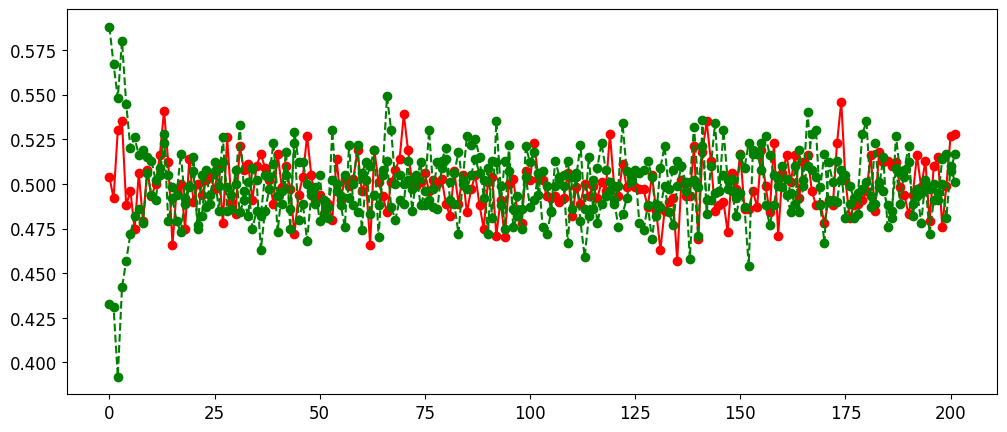

In [196]:
t = []
for i in range(1):
    t.append(0.2)
theta = np.array(t, requires_grad=True)
#print(theta)

diag = [VQSD(theta)]
Ev0 = [eval_readout(theta)[1]]
Ev1 = [eval_readout(theta)[0]]
#print(diag)
#print(Ev0)
#print(Ev1)

opt = qml.GradientDescentOptimizer(stepsize=0.2)
max_iterations = 1000
conv_tol = 1e-06
start_time = time.time()


for n in range(max_iterations):
    theta, prev_diag = opt.step_and_cost(VQSD, theta)

    diag.append(VQSD(theta))
    angle.append(theta)
    Ev0.append(eval_readout(theta)[1])
    Ev1.append(eval_readout(theta)[0])

    conv = np.abs(diag[-1])

    if n % 2 == 0:
        print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Value0 = {Ev0[-1]}, Eigen_Value1 = {Ev1[-1]}")

    if n == 200:
        max_iterations = n
        print("\n"f"Max iterations = {n}")
        break
    
    if conv <= conv_tol:
        max_iterations = n
        print("\n"f"Max iterations = {n}")
        break
print("\n" f"Optimization runtime = {time.time() - start_time}s")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
opt_angle = angle[-1]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1

plt.plot(range(len(diag)), diag, "ro", ls = "solid")
plt.plot(range(len(diag)), Ev0, "go", ls="dashed")
plt.plot(range(len(diag)), Ev1, "go", ls="dashed")
#plt.set_xlabel("Optimization step", fontsize=13)
#plt.set_ylabel("Diagonality", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

In [180]:
Average1 = sum(diag)/len(diag)
print(Average)

0.1212326732673267


In [184]:
Average2 = sum(diag)/len(diag)
print(Average2)

0.22142079207920812


In [192]:
Average4 = sum(diag)/len(diag)
print(Average4)

0.4201089108910893


In [189]:
Average5 = sum(diag)/len(diag)
print(Average5)

0.5014653465346535
